In [155]:
import time
from pytrends.request import TrendReq
from matplotlib import pyplot as plt
from tqdm import tqdm

# Vizu settings
%matplotlib inline
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import utils

In [156]:
LANGUAGE = 'en-US'
TIME_ZONE = 360

In [157]:
pytrends = TrendReq(hl=LANGUAGE, tz=TIME_ZONE)

In [158]:
COUNTRIES = utils.load_countries("countries.txt")

In [159]:
def get_trends(kw_list: list, tf: str, geo: str, sleep: float = 0.5):
    time.sleep(sleep)
    pytrends.build_payload(kw_list, timeframe=tf, geo=geo)
    return pytrends.interest_over_time().drop(columns=['isPartial'])

def plot_history(results: list, title: str):
    plt.figure()
    for data, label in results:
        plt.plot(data, label=label)
    plt.ylabel("Interest")
    plt.xlabel("Time")
    plt.legend(loc="upper right")
    plt.title(f"{title.capitalize()}: Interest Over Time")

def get_samples(time_period: str) -> list:
    
    search_history = []
    
    # Testing with a 10 random countries
    tmp_countries = COUNTRIES[100:110]

    for geocode, country in tqdm(tmp_countries):
        try:
            d = get_trends(search_term, time_period, geocode)
            search_history.append((d, country))
        except Exception as err:
            print("Exception on {}".format(country))
    return search_history

In [160]:
# Query params
search_term = ["fishing"]
time_period_A = "2015-1-1 2015-6-30"
time_period_B = "2015-7-1 2015-12-31"
# time_period = "today 5-y"

# Get data
search_history_A = []
search_history_B = []

In [161]:
search_history_A = get_samples(time_period_A)
search_history_B = get_samples(time_period_B)

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


In [162]:
# Few results
results_A = search_history_A[0:5]
results_B = search_history_B[0:5]

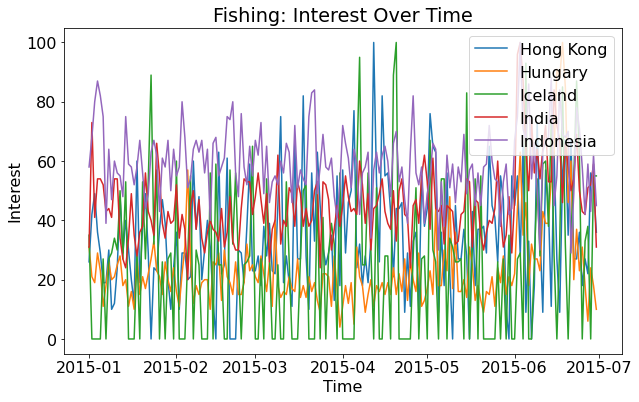

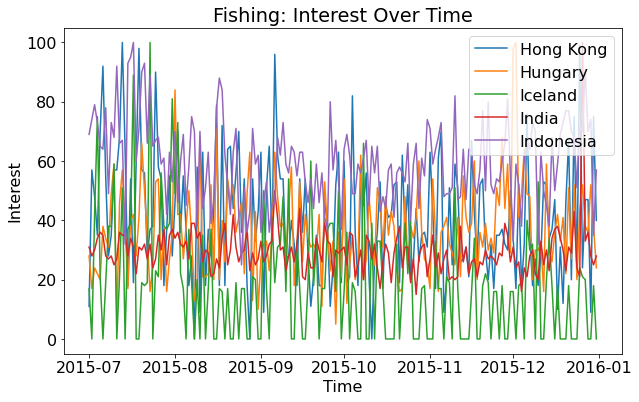

In [163]:
plot_history(results_A, search_term[0])
plot_history(results_B, search_term[0])